### Data Crawling & Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import time
import re
import nltk
import re
import warnings

### Combining of Dataset

Datasets were obtained from kaggle. To create a more comprehensive analysis, the datasets were combined to include in various Netflix content attributes.

* ```data.csv``` includes details such as content type, IMDb average rating, and available countries
* ```netflix_movies.csv``` provides additional attributes like director, cast, country, rating, and duration

In [2]:
data = pd.read_csv('data.csv', encoding='latin1')
netflix_data = pd.read_csv('netflix_movies.csv', encoding='utf-8')

merged_data = pd.merge(data, netflix_data, on='title', how='inner')
merged_data.drop(columns=['type_y'], inplace=True)
merged_data.drop(columns=['releaseYear'], inplace=True)
merged_data.rename(columns={'type_x': 'type'}, inplace=True)

merged_data.to_csv('merged_data.csv', index=False, encoding='utf-8')

### Crawling for Additional Data

Based on the ```imdbAverageRating``` from the combined dataset, reviews were crawled for the top 200 and bottom 200 pieces of content.

In [3]:
from bs4 import BeautifulSoup

def get_imdb_reviews(imdb_id):
    url = f'https://www.imdb.com/title/{imdb_id}/reviews/?ref_=tt_ov_ql_2'
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept-Language": "en-US,en;q=0.5"
    }
    response = requests.get(url, headers=headers)
    response.encoding = 'utf-8'

    soup = BeautifulSoup(response.text, 'html.parser')

    reviews = soup.select("div.ipc-html-content-inner-div")

    data = []
    for review in reviews:
        data.append({"imdbId": imdb_id, "Review": review.text.strip()})

    return data

def scrape_top_bottom_reviews():
    data = pd.read_csv('merged_data.csv', encoding='utf-8')

    top_100 = data.nlargest(200, 'imdbAverageRating')
    bottom_100 = data.nsmallest(200, 'imdbAverageRating')

    top_imdb_ids = top_100['imdbId'].tolist()
    bottom_imdb_ids = bottom_100['imdbId'].tolist()

    all_top_reviews = []
    for imdb_id in top_imdb_ids:
        movie_data = get_imdb_reviews(imdb_id)
        all_top_reviews.extend(movie_data)
        time.sleep(1)

    all_bottom_reviews = []
    for imdb_id in bottom_imdb_ids:
        movie_data = get_imdb_reviews(imdb_id)
        all_bottom_reviews.extend(movie_data)
        time.sleep(1)

    top_df = pd.DataFrame(all_top_reviews)
    bottom_df = pd.DataFrame(all_bottom_reviews)

    top_df.to_csv('imdb_top_200_reviews.csv', index=False, encoding='utf-8')
    bottom_df.to_csv('imdb_bottom_200_reviews.csv', index=False, encoding='utf-8')

    print("Reviews have been saved to 'imdb_top_200_reviews.csv' and 'imdb_bottom_200_reviews.csv'.")

scrape_top_bottom_reviews()


Reviews have been saved to 'imdb_top_200_reviews.csv' and 'imdb_bottom_200_reviews.csv'.


### Merge Crawled Reviews into Original Data

In [4]:
data = pd.read_csv('merged_data.csv', encoding='latin1')
top_reviews = pd.read_csv('imdb_top_200_reviews.csv')
bottom_reviews = pd.read_csv('imdb_bottom_200_reviews.csv')

merged_top = top_reviews.merge(data, left_on=["imdbId"], right_on=["imdbId"], how="left")
merged_bottom = bottom_reviews.merge(data, left_on=["imdbId"], right_on=["imdbId"], how="left")

merged_top.to_csv('merged_top_200_reviews.csv', index=False, encoding='utf-8')
merged_bottom.to_csv('merged_bottom_200_reviews.csv', index=False, encoding='utf-8')

print("Merged files have been saved as 'merged_top_200_reviews.csv' and 'merged_bottom_200_reviews.csv'.")


Merged files have been saved as 'merged_top_200_reviews.csv' and 'merged_bottom_200_reviews.csv'.


### Combine Top and Bottom Dataset

In [5]:
merged_top = pd.read_csv('merged_top_200_reviews.csv', encoding='utf-8')
merged_bottom = pd.read_csv('merged_bottom_200_reviews.csv', encoding='utf-8')

combined_reviews = pd.concat([merged_top, merged_bottom], ignore_index=True)

combined_reviews_grouped = combined_reviews.groupby(['title', 'imdbId']).agg({
    'type': 'first',
    'genres': 'first',
    'imdbAverageRating': 'first',
    'imdbNumVotes': 'first',
    'availableCountries': 'first',
    'show_id': 'first',
    'director': 'first',
    'cast': 'first',
    'country': 'first',
    'date_added': 'first',
    'release_year': 'first',
    'rating': 'first',
    'duration': 'first',
    'listed_in': 'first',
    'description': 'first',
    'Review': ' | '.join
}).reset_index()

columns = [col for col in combined_reviews_grouped.columns if col != 'Review'] + ['Review']
combined_reviews_grouped = combined_reviews_grouped[columns]

combined_reviews_grouped.to_csv('combined_data.csv', index=False, encoding='utf-8')

print("Combined reviews have been saved")


Combined reviews have been saved


### Check for Missing Entries



In [6]:
data_df = pd.read_csv('combined_data.csv', encoding='utf-8')

missing_info = data_df[data_df.isnull().any(axis=1)].copy()
missing_info['missing_columns'] = missing_info.apply(lambda row: row[row.isnull()].index.tolist(), axis=1)

print("Missing Values:")
for idx, row in missing_info.iterrows():
    print(f"Title: {row['title']}, Missing Columns: {row['missing_columns']}")


Missing Values:
Title: A Lion in the House, Missing Columns: ['cast']
Title: A Touch of Green, Missing Columns: ['director']
Title: Abstract: The Art of Design, Missing Columns: ['director']
Title: Absurd Planet, Missing Columns: ['director']
Title: After Life, Missing Columns: ['director']
Title: After the Raid, Missing Columns: ['cast']
Title: Alone, Missing Columns: ['director', 'cast', 'country']
Title: Anne with an E, Missing Columns: ['director']
Title: Arrested Development, Missing Columns: ['director']
Title: Arthdal Chronicles, Missing Columns: ['director']
Title: Ask the StoryBots, Missing Columns: ['director']
Title: Attack on Titan, Missing Columns: ['director']
Title: Avatar: The Last Airbender, Missing Columns: ['director']
Title: Bakugan: Battle Planet, Missing Columns: ['director']
Title: Better Call Saul, Missing Columns: ['director']
Title: Bhaag Beanie Bhaag, Missing Columns: ['director']
Title: Bill Nye Saves the World, Missing Columns: ['director']
Title: Black Mir

### Fill in the missing entries by crawling data from IMDb

In [7]:
def get_info(imdb_id):
    imdb_url = f"https://www.imdb.com/title/{imdb_id}/"
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept-Language": "en-US,en;q=0.5"
    }
    response = requests.get(imdb_url, headers=headers)
    response.encoding = 'utf-8'

    if response.status_code != 200:
        print(f"Failed to retrieve page for IMDb ID: {imdb_id}, status code: {response.status_code}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    director_tag = soup.find("a", class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link", href=True)

    if director_tag:
        director_name = director_tag.text.strip()
        return director_name
    else:
        print(f"Director tag not found for IMDb ID: {imdb_id}.")
        return None

data_df = pd.read_csv('combined_data.csv', encoding='utf-8')

missing_director_info = data_df[data_df['director'].isnull()].copy()
missing_cast_info = data_df[data_df['cast'].isnull()].copy()
missing_country_info = data_df[data_df['country'].isnull()].copy()

for idx, row in missing_director_info.iterrows():
    imdb_id = row['imdbId']
    director_name = get_info(imdb_id)
    if director_name:
        data_df.at[idx, 'director'] = director_name

for idx, row in missing_cast_info.iterrows():
    imdb_id = row['imdbId']
    cast_names = get_info(imdb_id)
    if cast_names:
        data_df.at[idx, 'cast'] = cast_names

for idx, row in missing_country_info.iterrows():
    imdb_id = row['imdbId']
    country = get_info(imdb_id)
    if country:
        data_df.at[idx, 'country'] = country

data_df.to_csv('updated_combined_data.csv', index=False, encoding='utf-8')

print("Updated dataset has been saved")

Updated dataset has been saved


### Check if all the missing values were handled correctly

In [8]:
data_df = pd.read_csv('updated_combined_data.csv', encoding='utf-8')

missing_info = data_df[data_df.isnull().any(axis=1)].copy()
missing_info['missing_columns'] = missing_info.apply(lambda row: row[row.isnull()].index.tolist(), axis=1)

print("Missing Values:")
for idx, row in missing_info.iterrows():
    print(f"Title: {row['title']}, Missing Columns: {row['missing_columns']}")


Missing Values:
Title: Friends, Missing Columns: ['date_added']
Title: Little Lunch, Missing Columns: ['rating']
Title: Louis C.K.: Hilarious, Missing Columns: ['duration']


### Handle the remaining missing values

* Check with online articles to find the missing values that could not be obtain via crawling
* For example, "Friends" was added to Netflix in 2015-01-01, based on the article
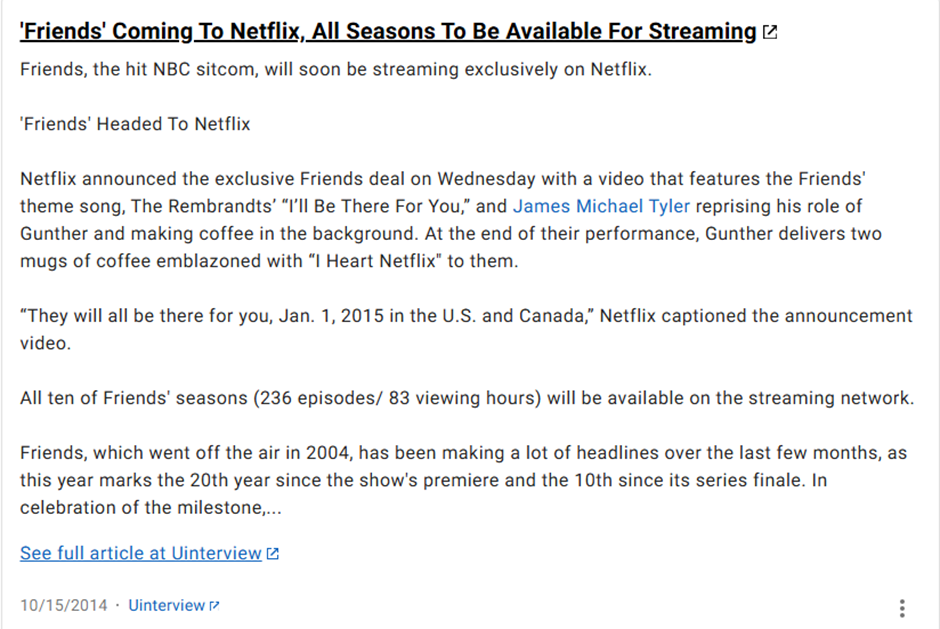

https://www.imdb.com/news/ni57876065/


* Relevant news articles were found for "Little Lunch", and "Louis C.K.: Hilarious"

In [9]:
data_df.loc[data_df['title'] == 'Friends', 'date_added'] = '2015-01-01'
data_df.loc[data_df['title'] == 'Little Lunch', 'rating'] = 'TV-G'
data_df.loc[data_df['title'] == 'Louis C.K.: Hilarious', 'duration'] = '82 min'

data_df.to_csv('updated_combined_data.csv', index=False, encoding='utf-8')

print("Updated date_added for 'Friends', 'Little Lunch', 'Louis C.K.: Hilarious' has been saved in 'updated_combined_data.csv'.")

Updated date_added for 'Friends', 'Little Lunch', 'Louis C.K.: Hilarious' has been saved in 'updated_combined_data.csv'.


### Feature Engineering

* Duration converted to int for numerical comparison
* Country Codes converted into a count
* Reviews text converted to lowercase, non-alphanumeric characters removed, stop words filtered out

</br>

Cleaned reviews were then transformed into numerical features using a TF-IDF Vectorizer, which extracted the top 100 most significant terms based on their importance across all reviews.
* Features were added to the dataset

</br>

Descriptions were processed similarly using a TF-IDF Vectorizer
* Maximum of 10 features
* Vectorizer excluded English stopwords
* Extracted features were incorporated into the dataset with columns prefixed by "Description_" for clarity.

In [10]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_data(dataframe):
    dataframe['genres_split'] = dataframe['genres'].str.split(', ')
    genres_encoded = pd.get_dummies(dataframe['genres_split'].explode()).groupby(level=0).sum()
    dataframe = pd.concat([dataframe, genres_encoded], axis=1)

    def clean_text_with_stopwords(text):
        text = re.sub(r'[^\w\s]', '', text.lower())
        words = text.split()
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    dataframe['cleaned_review'] = dataframe['Review'].apply(clean_text_with_stopwords)

    tfidf_vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf_vectorizer.fit_transform(dataframe['cleaned_review'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    dataframe = pd.concat([dataframe, tfidf_df], axis=1)

    return dataframe

file_path = 'updated_combined_data.csv'
netflix_data = pd.read_csv(file_path)
netflix_data = preprocess_data(netflix_data)

output_file_path = 'netflix_data_preprocessed.csv'
netflix_data.to_csv(output_file_path, index=False)

print(f"Preprocessed data has been saved to {output_file_path}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessed data has been saved to netflix_data_preprocessed.csv


### Basic Properties of Data (Statistical Analysis)

In [11]:
from scipy.stats import shapiro

# Load the dataset
file_path = 'netflix_data_preprocessed.csv'
netflix_data = pd.read_csv(file_path)

# Preprocess the duration column to extract numeric values
def extract_duration(value):
    try:
        return int(re.search(r'\d+', value).group())
    except:
        return None

netflix_data['duration'] = netflix_data['duration'].apply(extract_duration)

# Calculate mean and variance for IMDb Average Ratings
average_rating_mean = netflix_data['imdbAverageRating'].mean()
average_rating_variance = netflix_data['imdbAverageRating'].var()

# Check for normality using Shapiro-Wilk test for IMDb Average Ratings
stat, p_value = shapiro(netflix_data['imdbAverageRating'].dropna())
distribution_result = "near-normal distribution" if p_value > 0.05 else "non-normal distribution"

# Analyze Content Duration
duration_mean = netflix_data['duration'].mean()
duration_min = netflix_data['duration'].min()
duration_max = netflix_data['duration'].max()

# Analyze Genre Frequency (if 'genres' column exists)
if 'genres' in netflix_data.columns:
    genre_counts = netflix_data['genres'].str.split(', ').explode().value_counts()
    top_genres = genre_counts.index[:3].tolist()

# Print Results
print(f"IMDb ratings had a mean of approximately {average_rating_mean:.2f}, "
      f"with a variance of {average_rating_variance:.2f}, "
      f"and followed a {distribution_result} with a slight skew toward higher ratings.")
print()
print(f"Content duration ranged from {duration_min} to {duration_max} minutes, "
      f"with a mean of approximately {duration_mean:.2f} minutes.")
print()
if 'genres' in netflix_data.columns:
    print(f"{', '.join(top_genres)} emerged as the most frequently occurring genres.")

IMDb ratings had a mean of approximately 6.40, with a variance of 5.04, and followed a non-normal distribution with a slight skew toward higher ratings.

Content duration ranged from 1 to 203 minutes, with a mean of approximately 58.06 minutes.

Drama, Comedy, Action emerged as the most frequently occurring genres.


## Graph Visualisations

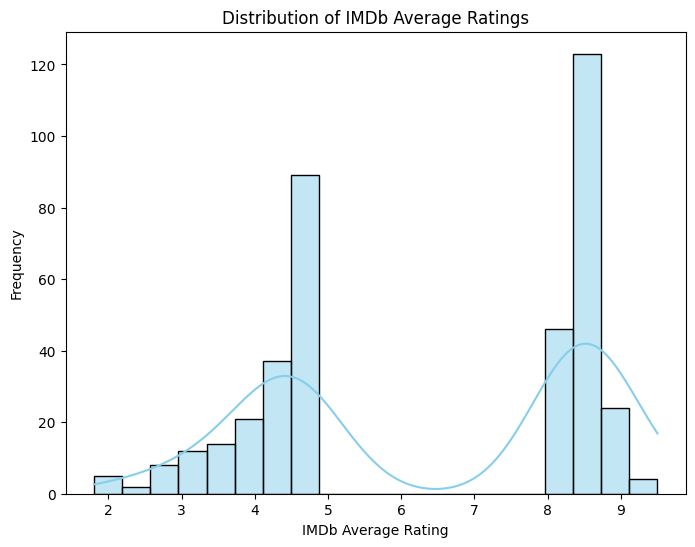

In [12]:
# 1. Histogram for IMDb Average Ratings
plt.figure(figsize=(8, 6))
sb.histplot(netflix_data['imdbAverageRating'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of IMDb Average Ratings')
plt.xlabel('IMDb Average Rating')
plt.ylabel('Frequency')
plt.show()

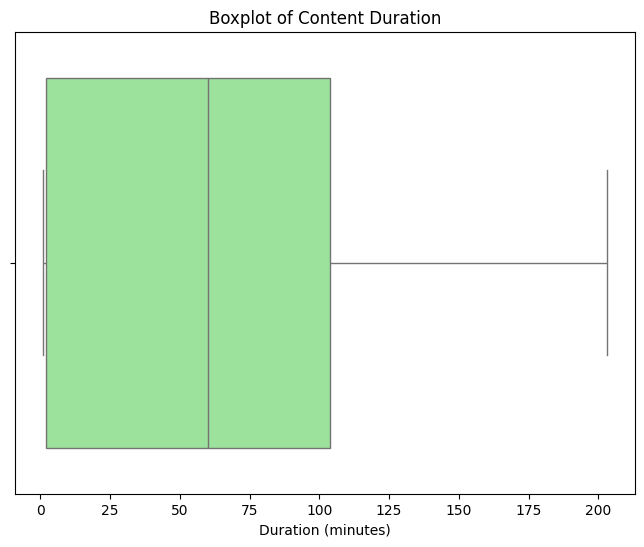

In [13]:
# 2. Boxplot for Content Duration
plt.figure(figsize=(8, 6))
sb.boxplot(x=netflix_data['duration'].dropna(), color='lightgreen')
plt.title('Boxplot of Content Duration')
plt.xlabel('Duration (minutes)')
plt.show()

<ipython-input-14-4f51d892ceea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10], palette='viridis')


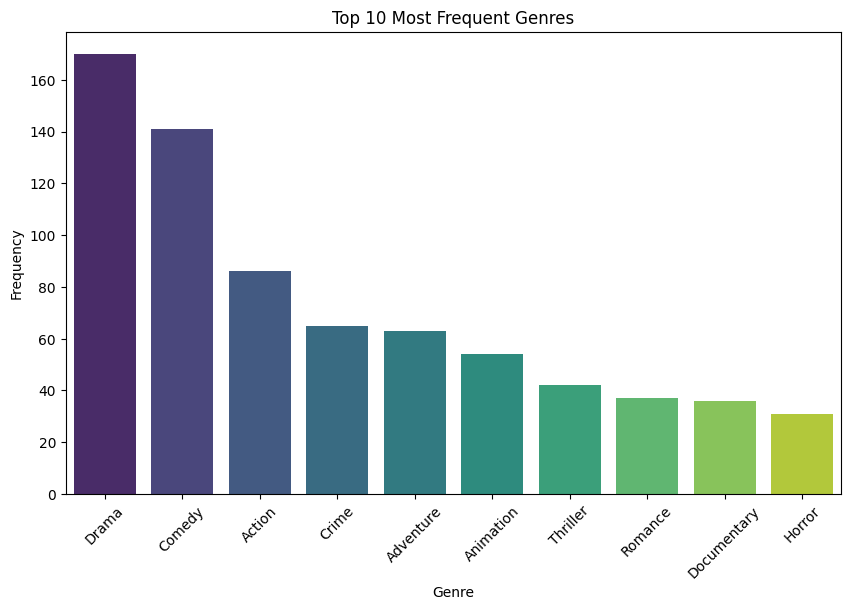

In [14]:
# 3. Top Genres Bar Plot
if 'genres' in netflix_data.columns:
    plt.figure(figsize=(10, 6))
    sb.barplot(x=genre_counts.index[:10], y=genre_counts.values[:10], palette='viridis')
    plt.title('Top 10 Most Frequent Genres')
    plt.xlabel('Genre')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

<ipython-input-15-bf6c8dade198>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=type_counts.index, y=type_counts.values, palette='coolwarm')


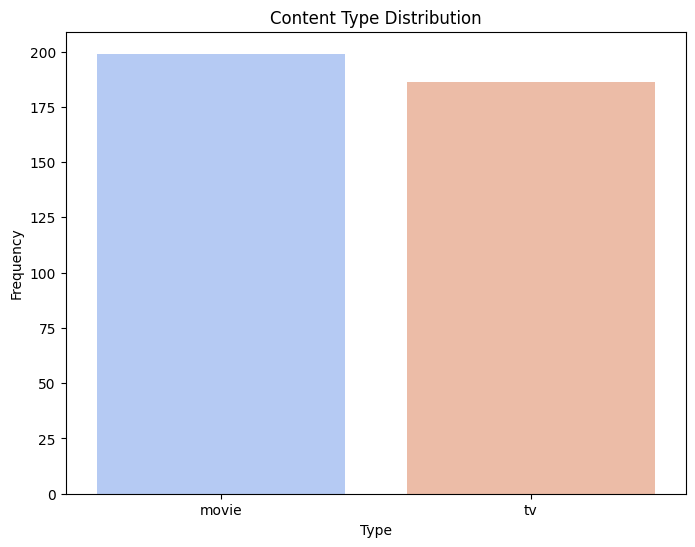

In [15]:
# 4. Bar Plot for Content Type
plt.figure(figsize=(8, 6))
type_counts = netflix_data['type'].value_counts()
sb.barplot(x=type_counts.index, y=type_counts.values, palette='coolwarm')
plt.title('Content Type Distribution')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.show()

### Data Mining Alogrithms

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud

data = pd.read_csv('netflix_data_preprocessed.csv', encoding='utf-8')

rating_threshold = data['imdbAverageRating'].median()
data['success'] = data['imdbAverageRating'] >= rating_threshold

data['genres'] = data['genres'].fillna('').str.split(', ')
all_genres = list(set([genre for sublist in data['genres'] for genre in sublist]))
for genre in all_genres:
    data[genre] = data['genres'].apply(lambda x: 1 if genre in x else 0)

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Review'])

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.13805916 0.0452583 ]


In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(pca_result)

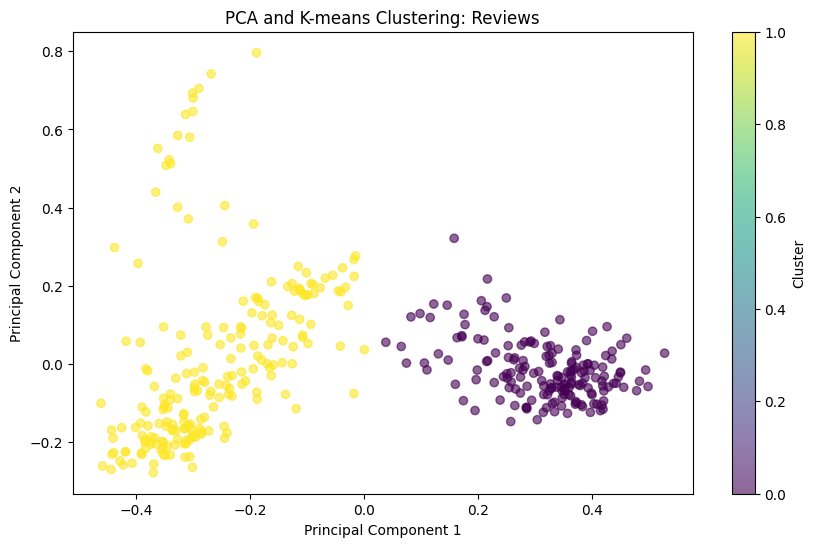

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(data['PCA1'], data['PCA2'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.title('PCA and K-means Clustering: Reviews')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

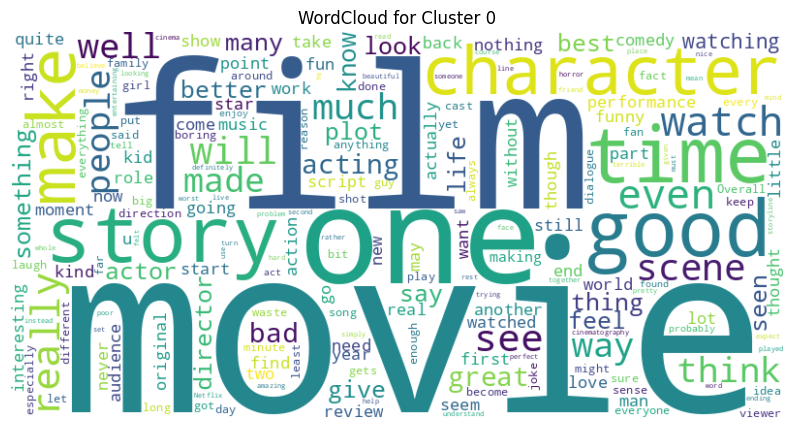

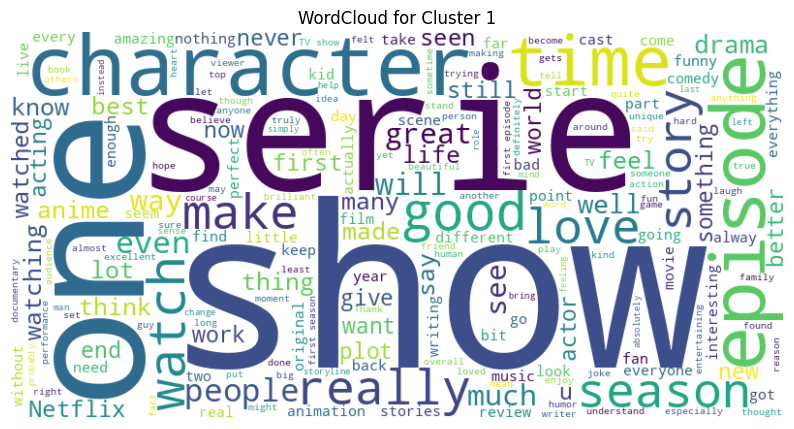

In [20]:
#PCA K-means cluster for reviews plot visualisation
from sklearn.preprocessing import StandardScaler

for cluster_label in data['cluster'].unique():
    cluster_reviews = ' '.join(data[data['cluster'] == cluster_label]['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_reviews)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_label}')
    plt.show()

In [21]:
#WordCloud visualisation
from wordcloud import WordCloud

for cluster_label in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster_label]
    print(f"\nCluster {cluster_label} Characteristics:")
    print(f"Average IMDb Rating: {cluster_data['imdbAverageRating'].mean():.2f}")


Cluster 0 Characteristics:
Average IMDb Rating: 5.05

Cluster 1 Characteristics:
Average IMDb Rating: 7.52


In [22]:
data.to_csv('review_analysis_results.csv', index=False)
print("Results saved to 'review_analysis_results.csv'")

Results saved to 'review_analysis_results.csv'


### Apriori Association Analysis

In [23]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings("ignore", category=DeprecationWarning)

file_path = 'netflix_data_preprocessed.csv'
netflix_data_preprocessed = pd.read_csv(file_path)

clustering_data = netflix_data_preprocessed[['imdbAverageRating', 'type', 'availableCountries',
                                             'director', 'cast', 'country', 'release_year',
                                             'rating', 'duration', 'description']].copy()


In [24]:
def extract_duration(value):
    try:
        return int(value.split()[0])
    except:
        return 0

In [25]:
def count_countries(value):
    if value == "Unknown":
        return 0
    return len(value.split(', '))

In [26]:
clustering_data['duration'] = clustering_data['duration'].apply(extract_duration)
clustering_data['availableCountriesCount'] = clustering_data['availableCountries'].apply(count_countries)

top_directors = netflix_data_preprocessed['director'].value_counts().head(10).index
top_cast = netflix_data_preprocessed['cast'].value_counts().head(10).index
clustering_data['is_top_director'] = clustering_data['director'].apply(lambda x: 1 if any(d in x for d in top_directors) else 0)
clustering_data['is_top_cast'] = clustering_data['cast'].apply(lambda x: 1 if any(c in x for c in top_cast) else 0)

vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
description_tfidf = vectorizer.fit_transform(clustering_data['description'])
tfidf_df = pd.DataFrame(description_tfidf.toarray(), columns=[f"Description_{col}" for col in vectorizer.get_feature_names_out()])
clustering_data = pd.concat([clustering_data, tfidf_df], axis=1)
clustering_data = pd.get_dummies(clustering_data, columns=['type'], drop_first=False)
categorical_columns = ['country', 'rating']
clustering_data = pd.get_dummies(clustering_data, columns=categorical_columns, drop_first=True)

clustering_data.drop(columns=['director', 'cast', 'description', 'availableCountries'], inplace=True)

In [27]:
print("\nPerforming Apriori analysis on the entire dataset...")
clustering_data['transactions'] = clustering_data.apply(
    lambda row: [
        f"Director_Top" if row['is_top_director'] == 1 else None,
        f"Cast_Top" if row['is_top_cast'] == 1 else None,
        f"High_Rating" if row['imdbAverageRating'] >= 7 else "Low_Rating",
        f"Short_Duration" if row['duration'] <= 90 else "Long_Duration",
        f"Multi_Countries" if row['availableCountriesCount'] > 5 else "Single_Country"
    ] + [
        f"{col}" for col in row.index if col.startswith('type_') and row[col] == 1
    ] + [
        f"{col}" for col in row.index if col.startswith('country_') and row[col] == 1
    ] + [
        f"{col}" for col in row.index if col.startswith('rating_') and row[col] == 1
    ], axis=1
)
clustering_data['transactions'] = clustering_data['transactions'].apply(lambda x: [item for item in x if item])
transactions = clustering_data['transactions']
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
apriori_binary = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(apriori_binary, min_support=0.01, use_colnames=True)

if not frequent_itemsets.empty:
    try:
        if 'num_itemsets' in association_rules.__code__.co_varnames:
            num_itemsets = frequent_itemsets['itemsets'].apply(len).sum()
            rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2, num_itemsets=num_itemsets)
        else:
            rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

        if not rules.empty:
            print("\nTop Apriori Rules (Entire Dataset):")
            print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))
        else:
            print("\nNo association rules found for the dataset.")
    except Exception as e:
        print(f"\nError in generating association rules: {e}")
else:
    print("\nNo frequent itemsets found for Apriori analysis.")


Performing Apriori analysis on the entire dataset...

Top Apriori Rules (Entire Dataset):
                antecedents              consequents   support  confidence  \
0            (Director_Top)               (Cast_Top)  0.015584    0.250000   
1                (Cast_Top)           (Director_Top)  0.015584    0.300000   
2                (Cast_Top)            (High_Rating)  0.041558    0.800000   
3             (High_Rating)               (Cast_Top)  0.041558    0.081218   
4          (Single_Country)               (Cast_Top)  0.015584    0.078947   
5                (Cast_Top)         (Single_Country)  0.015584    0.300000   
6   (country_United States)               (Cast_Top)  0.020779    0.065041   
7                (Cast_Top)  (country_United States)  0.020779    0.400000   
8            (rating_TV-MA)               (Cast_Top)  0.036364    0.086957   
9                (Cast_Top)           (rating_TV-MA)  0.036364    0.700000   
10           (rating_TV-PG)               (Cast_Top

### K-Means Clustering with PCA reduction on various variables

In [28]:
clustering_data.drop(columns=['transactions'], inplace=True)

kmeans = KMeans(n_clusters=3, random_state=42)
clustering_data['KMeans_Cluster'] = kmeans.fit_predict(clustering_data)

In [29]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data.iloc[:, :-1])
clustering_data['PCA1'] = pca_data[:, 0]
clustering_data['PCA2'] = pca_data[:, 1]

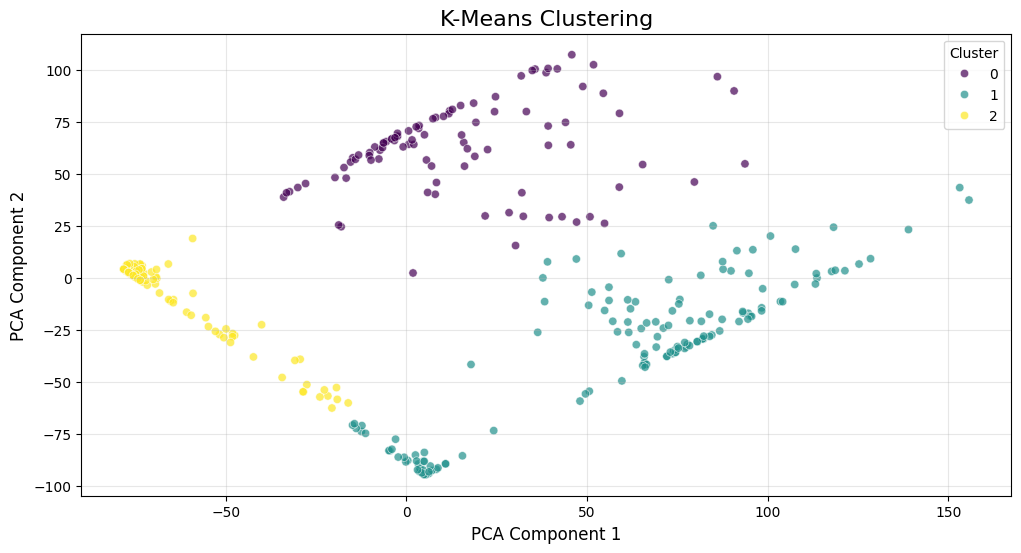

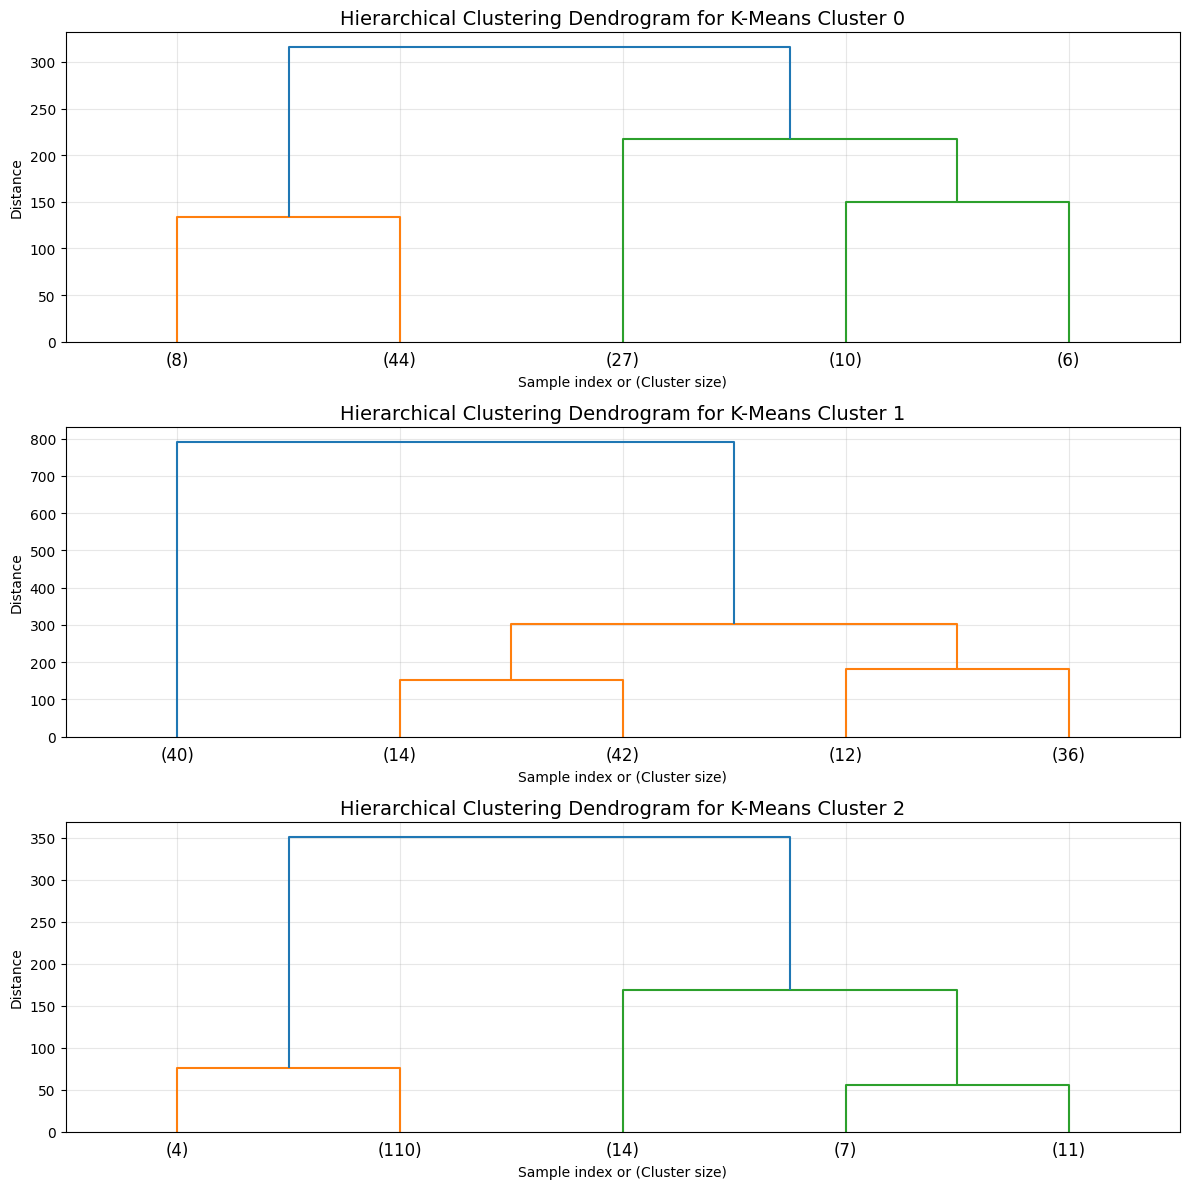

In [30]:
plt.figure(figsize=(12, 6))
sb.scatterplot(data=clustering_data, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', alpha=0.7)
plt.title('K-Means Clustering', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()
fig, axes = plt.subplots(len(clustering_data['KMeans_Cluster'].unique()), 1, figsize=(12, 4 * len(clustering_data['KMeans_Cluster'].unique())))

for idx, cluster_label in enumerate(sorted(clustering_data['KMeans_Cluster'].unique())):
    cluster_data = clustering_data[clustering_data['KMeans_Cluster'] == cluster_label].copy()
    linkage_matrix = linkage(cluster_data.iloc[:, :-3], method='ward')
    ax = axes[idx] if len(clustering_data['KMeans_Cluster'].unique()) > 1 else axes
    dendrogram(linkage_matrix, truncate_mode='lastp', p=5, ax=ax)
    ax.set_title(f'Hierarchical Clustering Dendrogram for K-Means Cluster {cluster_label}', fontsize=14)
    ax.set_xlabel('Sample index or (Cluster size)')
    ax.set_ylabel('Distance')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
all_cluster_summaries = []
type_analysis = []

#### K-Means Cluster Summary Analysis for Hierarchical Subclusters

<ipython-input-31-d1bd6ed632fa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='Hierarchical_Cluster', y='imdbAverageRating', data=cluster_data, palette='viridis')


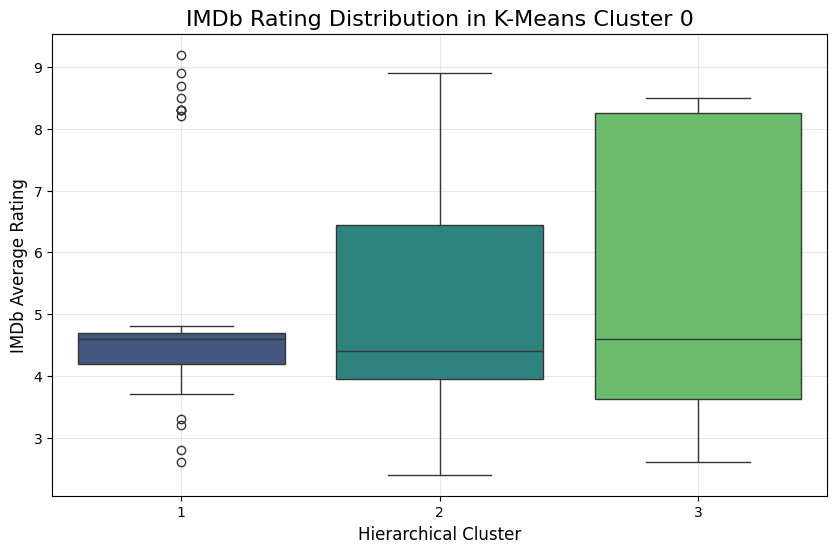

<ipython-input-31-d1bd6ed632fa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='Hierarchical_Cluster', y='imdbAverageRating', data=cluster_data, palette='viridis')


Summary for K-Means Cluster 0 - Hierarchical Subclusters:
                      imdbAverageRating    duration  availableCountriesCount
Hierarchical_Cluster                                                        
1                              5.048077   90.961538               122.826923
2                              5.188889  136.888889               121.407407
3                              5.518750  125.937500                74.250000
Type Columns in Cluster 0: ['type_movie', 'type_tv']

Type Distribution for K-Means Cluster 0:
                      type_movie  type_tv  KMeans_Cluster
Hierarchical_Cluster                                     
1                             50        2               0
2                             25        2               0
3                             16        0               0


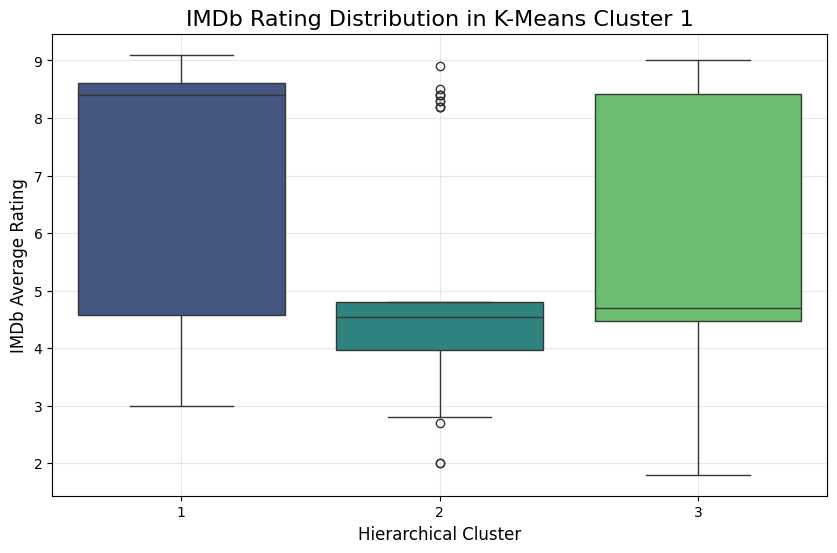

Summary for K-Means Cluster 1 - Hierarchical Subclusters:
                      imdbAverageRating    duration  availableCountriesCount
Hierarchical_Cluster                                                        
1                              7.312500    4.925000                10.100000
2                              4.889286   89.714286                13.839286
3                              6.079167  131.166667                 9.750000
Type Columns in Cluster 1: ['type_movie', 'type_tv']

Type Distribution for K-Means Cluster 1:
                      type_movie  type_tv  KMeans_Cluster
Hierarchical_Cluster                                     
1                              7       33               1
2                             55        1               1
3                             45        3               1


<ipython-input-31-d1bd6ed632fa>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='Hierarchical_Cluster', y='imdbAverageRating', data=cluster_data, palette='viridis')


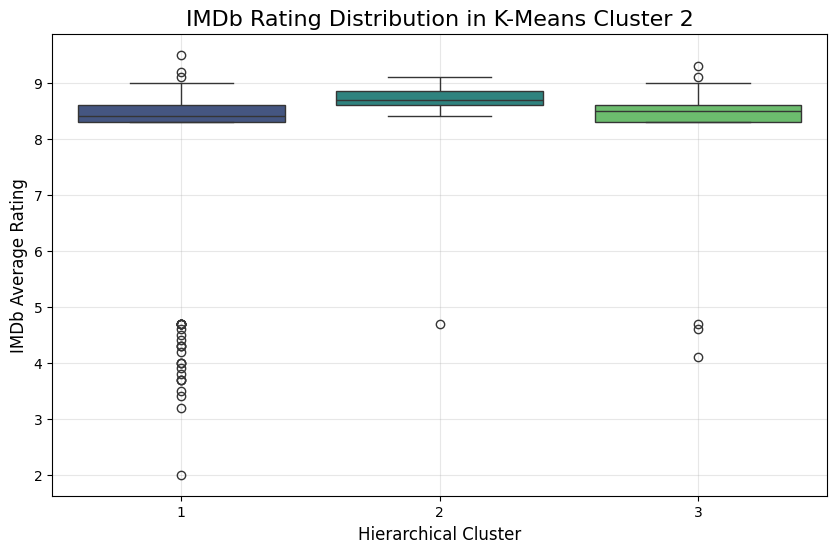

Summary for K-Means Cluster 2 - Hierarchical Subclusters:
                      imdbAverageRating  duration  availableCountriesCount
Hierarchical_Cluster                                                      
1                              7.488596  2.456140               127.035088
2                              8.442857  4.642857                53.642857
3                              7.911111  2.833333                96.111111
Type Columns in Cluster 2: ['type_movie', 'type_tv']

Type Distribution for K-Means Cluster 2:
                      type_movie  type_tv  KMeans_Cluster
Hierarchical_Cluster                                     
1                              1      113               2
2                              0       14               2
3                              0       18               2


In [31]:
for cluster_label in sorted(clustering_data['KMeans_Cluster'].unique()):
    cluster_data = clustering_data[clustering_data['KMeans_Cluster'] == cluster_label].copy()
    linkage_matrix = linkage(cluster_data.iloc[:, :-3], method='ward')
    cluster_data['Hierarchical_Cluster'] = fcluster(linkage_matrix, t=3, criterion='maxclust')
    clustering_data.loc[clustering_data['KMeans_Cluster'] == cluster_label, 'Hierarchical_Cluster'] = cluster_data['Hierarchical_Cluster']

    cluster_summary = cluster_data.groupby('Hierarchical_Cluster').mean()
    all_cluster_summaries.append(cluster_summary)
    plt.figure(figsize=(10, 6))
    sb.boxplot(x='Hierarchical_Cluster', y='imdbAverageRating', data=cluster_data, palette='viridis')
    plt.title(f'IMDb Rating Distribution in K-Means Cluster {cluster_label}', fontsize=16)
    plt.xlabel('Hierarchical Cluster', fontsize=12)
    plt.ylabel('IMDb Average Rating', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Summary for K-Means Cluster {cluster_label} - Hierarchical Subclusters:")
    print(cluster_summary[['imdbAverageRating', 'duration', 'availableCountriesCount']])

    type_cols = [col for col in cluster_data.columns if col.startswith('type_')]
    print(f"Type Columns in Cluster {cluster_label}:", type_cols)
    type_dist = cluster_data.groupby('Hierarchical_Cluster')[type_cols].sum()
    type_dist['KMeans_Cluster'] = cluster_label
    type_analysis.append(type_dist)

    print(f"\nType Distribution for K-Means Cluster {cluster_label}:")
    print(type_dist)

In [32]:
summary_tables = []
for cluster_label, summary in enumerate(all_cluster_summaries):
    summary_table = summary.reset_index()
    summary_table['KMeans_Cluster'] = cluster_label
    summary_tables.append(summary_table)

In [33]:
summary_df = pd.concat(summary_tables, ignore_index=True)
print("\nSummary of All Subclusters:")
print(summary_df)


Summary of All Subclusters:
   Hierarchical_Cluster  imdbAverageRating  release_year    duration  \
0                     1           5.048077   2016.730769   90.961538   
1                     2           5.188889   2014.185185  136.888889   
2                     3           5.518750   2013.000000  125.937500   
3                     1           7.312500   2015.525000    4.925000   
4                     2           4.889286   2013.178571   89.714286   
5                     3           6.079167   2008.729167  131.166667   
6                     1           7.488596   2018.342105    2.456140   
7                     2           8.442857   2015.000000    4.642857   
8                     3           7.911111   2016.333333    2.833333   

   availableCountriesCount  is_top_director  is_top_cast  Description_city  \
0               122.826923         0.076923     0.096154          0.028622   
1               121.407407         0.037037     0.000000          0.000000   
2               

In [34]:
type_analysis_df = pd.concat(type_analysis)
print("\nCombined Type Analysis Summary:")
print(type_analysis_df)


Combined Type Analysis Summary:
                      type_movie  type_tv  KMeans_Cluster
Hierarchical_Cluster                                     
1                             50        2               0
2                             25        2               0
3                             16        0               0
1                              7       33               1
2                             55        1               1
3                             45        3               1
1                              1      113               2
2                              0       14               2
3                              0       18               2


### Prediction Model

In [35]:
X = clustering_data.drop(columns=['KMeans_Cluster', 'Hierarchical_Cluster', 'PCA1', 'PCA2'])
y = clustering_data['KMeans_Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
y_pred = rf_model.predict(X_test)
print("\nK-Means Cluster Prediction Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


K-Means Cluster Prediction Performance:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.98      0.99        54
           2       1.00      0.97      0.99        34

    accuracy                           0.98       116
   macro avg       0.98      0.98      0.98       116
weighted avg       0.98      0.98      0.98       116

Accuracy: 0.98


In [37]:
def predict_cluster_success(content_data):
    full_feature_set = X_train.columns
    content_data = content_data.reindex(columns=full_feature_set, fill_value=0)

    content_cluster = rf_model.predict(content_data)
    print("\nPredicted K-Means Cluster:", content_cluster[0])

    cluster_avg_rating = clustering_data[clustering_data['KMeans_Cluster'] == content_cluster[0]]['imdbAverageRating'].mean()
    print(f"Cluster {content_cluster[0]} Average IMDb Rating: {cluster_avg_rating:.2f}")
    success_threshold = 7.0
    if cluster_avg_rating >= success_threshold:
        print("Predicted Success: High")
    else:
        print("Predicted Success: Low")

In [38]:
new_content = pd.DataFrame([{
    'imdbAverageRating': 8.0,
    'duration': 120,
    'availableCountriesCount': 10,
    'is_top_director': 1,
    'is_top_cast': 0,
    'type_movie': 1,
    'type_tv': 0,
    'country_US': 1,
    'country_UK': 0,
    'rating_TV-MA': 1,
    'rating_TV-14': 0,
    'Description_life': 0.1,
    'Description_love': 0.2,
    'Description_young': 0.0
}])

predict_cluster_success(new_content)


Predicted K-Means Cluster: 1
Cluster 1 Average IMDb Rating: 5.96
Predicted Success: Low
